In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [3]:
def get_data_event(event_name, data):
    
    df = data[['user_id', 'event_data']].loc[data['event_name']==event_name]
    
    if event_name == 'levelEnd':
        regex_sub = re.compile(r'\[([",A-Za-z]+|'')\]')
        for i in range(df.shape[0]):
            df['event_data'].iloc[i] = re.sub(regex_sub, '"NoData"', # нужно поправить
                                              df['event_data'].iloc[i])        
    
    # спличу данные на отдельные столбцы
    split_data = df['event_data'].str.split(pat=',')
    
    if event_name == 'levelEnd':
        split_data = list(map(lambda x: x[:5]+x[6:] if len(x) == 19 else x, 
                              split_data))
        split_data = pd.DataFrame(split_data, index=df.index)
        
    elif event_name == 'levelStart':
        split_data = list(map(lambda x: x[:4]+x[5:] if len(x) == 12 else x, 
                              split_data))
        split_data = pd.DataFrame(split_data, index=df.index)

    # регулярка для поиска названия столбцов
    regex_col_names = re.compile(r'"([a-zA-z0-9]+)":', 
                                 re.UNICODE) 
    
    # записываю названия будущих столбцов
    column_names = list(map(lambda x: regex_col_names.findall(x)[0], 
                        split_data.iloc[0])) 
    
    # добавляю к названиям имя ивента
    column_names = list(map(lambda x: '_'.join([x, event]), 
                            column_names))
    
    # регулярка для поиска значений столбцов
    regex_col_values = re.compile(r':"*([-A-Za-z0-9_]+|'')') 
    
    # получаю значения колонок и записываю их в массив
    game_status_data = pd.DataFrame(index=df.index, columns=column_names)
    for i in game_status_data.index:
        game_status_data.loc[i] = list(map(lambda x: regex_col_values.findall(x)[0], split_data.loc[i]))

    df = df.drop('event_data', axis=1)
    df = df.merge(game_status_data, how='left', left_index=True, right_index=True)
    
    return df

---

In [4]:
data = pd.read_csv(r'C:\Users\home\Desktop\analysis\data.csv')

In [5]:
data.head()

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
0,60c588d7b4d1b24b40531f29,organic,2021-06-05 07:23:06,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""Xiaomi POCO M2 Pro"",""graphicMemory""..."
1,60d34c7ab4d1b24b405324ac,organic,2021-06-05 16:33:26,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-J200G"",""graphicMemory"":2..."
2,60babef87c80da6a9442cb86,ad-traffic,2021-06-05 00:02:07,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-G781B"",""graphicMemory"":2..."
3,60bac0e912667e6a8d107731,ad-traffic,2021-06-05 00:04:29,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-T290"",""graphicMemory"":51..."
4,60babfb17c80da6a9442cb87,organic,2021-06-05 00:05:16,1,"{""coins"":0,""freeRounds"":0,""freeUndo"":0,""freeWi...",appInstall,"{""device"":""samsung SM-N960F"",""graphicMemory"":2..."


In [6]:
data.tail()

,user_id,media_source,client_time,session_index,game_status,event_name,event_data
396094,60bb2f3912667e6a8d107757,organic,2021-06-12 11:52:41,54,"{""coins"":1174190,""freeRounds"":30,""freeUndo"":30...",transactionComplete,"{""inLevel"":false,""usdProceed"":68.1768094378241..."
396095,60bb2f3912667e6a8d107757,organic,2021-06-12 15:18:06,57,"{""coins"":7885,""freeRounds"":0,""freeUndo"":394,""f...",transactionComplete,"{""inLevel"":false,""usdProceed"":6.81001009386441..."
396096,60bb2f3912667e6a8d107757,organic,2021-06-12 15:18:30,57,"{""coins"":107885,""freeRounds"":0,""freeUndo"":394,...",transactionComplete,"{""inLevel"":false,""usdProceed"":13.6285433543043..."
396097,60bc090c12667e6a8d1077b8,organic,2021-06-12 22:48:26,2,"{""coins"":45274,""freeRounds"":0,""freeUndo"":3,""fr...",transactionComplete,"{""inLevel"":false,""usdProceed"":1.393,""productDe..."
396098,60bbf4a373c31e6a292b7ad1,ad-traffic,2021-06-12 23:27:05,99,"{""coins"":8789,""freeRounds"":0,""freeUndo"":0,""fre...",transactionComplete,"{""inLevel"":true,""usdProceed"":1.391999345326586..."


---

## Prepare data for analysis 

### Column game_status	

In [7]:
game_st = data[['user_id', 'game_status']]

In [8]:
game_status_split = game_st['game_status'].str.split(pat=',') #спличу данные на отдельные столбцы

In [9]:
col_game_st = list(map(lambda x: re.sub('[^A-Za-z]', '', x),      # получаю названия будущих столбцов.
                       game_status_split[0][:9]))                 # пришлось обрезать кол-во столбцов
                                                                  # т.к в некоторых строках нет последних
                                                                  # 3-x столбцов

In [10]:
col_game_st = list(map(lambda x: '_'.join([x, 'game_status']), col_game_st))

In [11]:
game_status_data = np.empty((game_st.shape[0], len(col_game_st)), dtype=int)
for i in range(game_st.shape[0]):
    game_status_data[i] = list(map(lambda x: re.sub('[^0-9]', '', x), game_status_split[i][:9]))
    
# получаю значения колонок и записываю их в массив

In [12]:
game_status_data = pd.DataFrame(game_status_data, columns=col_game_st) # преобразую массив в DF

In [13]:
game_st = game_st.drop('game_status', axis=1)

In [14]:
game_status_data = game_st.merge(game_status_data, left_index=True, right_index=True) # объяединяю два DF

In [15]:
game_status_data.head()

,user_id,coins_game_status,freeRounds_game_status,freeUndo_game_status,freeWildCard_game_status,freeAddCards_game_status,level_game_status,map_game_status,bet_game_status,gladeId_game_status
0,60c588d7b4d1b24b40531f29,0,0,0,0,0,0,1,1,1
1,60d34c7ab4d1b24b405324ac,0,0,0,0,0,0,1,1,1
2,60babef87c80da6a9442cb86,0,0,0,0,0,0,1,1,1
3,60bac0e912667e6a8d107731,0,0,0,0,0,0,1,1,1
4,60babfb17c80da6a9442cb87,0,0,0,0,0,0,1,1,1


### Column event_data

#### Event appInstall

In [16]:
event = 'appInstall'

In [17]:
appInstall_data = get_data_event(event, data)

In [18]:
appInstall_data.head()

,user_id,device_appInstall,graphicMemory_appInstall,systemMemory_appInstall
0,60c588d7b4d1b24b40531f29,Xiaomi,2048,5582
1,60d34c7ab4d1b24b405324ac,samsung,256,892
2,60babef87c80da6a9442cb86,samsung,2048,5562
3,60bac0e912667e6a8d107731,samsung,512,1847
4,60babfb17c80da6a9442cb87,samsung,2048,5616


#### Event learning

In [19]:
event = 'learning'

In [20]:
learning_data = get_data_event(event, data)

In [21]:
learning_data.head()

,user_id,name_learning,level_learning
813,60bb736b12667e6a8d107774,CRUISE_USE_BOOSTERS_MORE,82
814,60bba5ea7c80da6a9442cbf3,CRUISE_USE_BOOSTERS_MORE,192
815,60bb736b12667e6a8d107774,CRUISE_USE_BOOSTERS_MORE,82
816,60bb736b12667e6a8d107774,CRUISE_USE_BOOSTERS_MORE,82
817,60bba5ea7c80da6a9442cbf3,CRUISE_USE_BOOSTERS_MORE,194


#### Event getCoins

In [22]:
event = 'getCoins'

In [23]:
get_coins_data = get_data_event(event, data)

In [24]:
get_coins_data.head()

,user_id,amount_getCoins,from_getCoins
451,60baf7b612667e6a8d107740,1200,LevelBonus
452,60bba6a74770af6a2faa05c4,-1000,LevelStart
453,60baefee4770af6a2faa0565,-2000,LevelStart
454,60bad8307c80da6a9442cb91,2308,LevelBonus
455,60baf2267c80da6a9442cb98,5966,LevelBonus


#### Event gladeComplete

In [25]:
event = 'gladeComplete'

In [26]:
gladeComplete_data = get_data_event(event, data)

In [89]:
gladeComplete_data.head()

,user_id,levels_gladeComplete
200998,60bb1bac12667e6a8d10774e,63
200999,60bb1bac12667e6a8d10774e,39
201000,60bb66084770af6a2faa05a0,10
201001,60bb7de34770af6a2faa05ab,6
201002,60bb46a573c31e6a292b7a79,41


#### Event getBooster

In [28]:
event = 'getBooster'

In [29]:
getBooster_data = get_data_event(event, data)

In [30]:
getBooster_data.head()

,user_id,type_getBooster,from_getBooster,amount_getBooster
2348,60c588d7b4d1b24b40531f29,freeUndo,FirstGift,5
2349,60c588d7b4d1b24b40531f29,freeExtraCards,FirstGift,5
2350,60c588d7b4d1b24b40531f29,freeWildCard,FirstGift,5
2351,60c588d7b4d1b24b40531f29,freeLevels,DailyBonus,3
2352,60c588d7b4d1b24b40531f29,freeLevels,UseInGame,-1


#### Event levelEnd

In [31]:
event = 'levelEnd'

In [32]:
levelEnd_data = get_data_event(event, data)

In [33]:
levelEnd_data = levelEnd_data.drop('streaksRewards_levelEnd', axis=1)

In [34]:
levelEnd_data.head()

,user_id,time_levelEnd,fromMenu_levelEnd,level_levelEnd,levelLoop_levelEnd,gameType_levelEnd,win_levelEnd,collectedCoins_levelEnd,bonusCoins_levelEnd,stars_levelEnd,cardsOnField_levelEnd,cardsOnHands_levelEnd,baseLuckyIndex_levelEnd,targetGoldIndex_levelEnd,totalLuckyIndex_levelEnd,cardsRemainsBonus_levelEnd,prediction_levelEnd,predictionCameTrue_levelEnd
39849,60babef87c80da6a9442cb86,32549,false,1,1,0,VICTORY,3088,0,5,0,17,0,0,0,1580,Default,false
39850,60babef87c80da6a9442cb86,45005,false,2,6,0,VICTORY,1214,0,3,0,3,0,0,0,90,VictoryWith1Or2Cards,true
39851,60babef87c80da6a9442cb86,49074,false,3,7,0,VICTORY_WITH_BOOSTER,1245,0,2,0,5,0,0,0,150,VictoryWith4OrMoreCards,true
39852,60bac0e912667e6a8d107731,29419,false,1,1,0,VICTORY,3158,0,5,0,17,0,0,0,1620,Default,false
39853,60babfb17c80da6a9442cb87,31960,false,1,1,0,VICTORY,3128,0,5,0,17,0,0,0,1660,Default,false


#### Event getStarsCruise

In [35]:
event = 'getStarsCruise'

In [36]:
getStarsCruise_data = get_data_event(event, data)

In [37]:
getStarsCruise_data.head()

,user_id,amount_getStarsCruise
169548,60bad8307c80da6a9442cb91,2
169549,60bad8307c80da6a9442cb91,1
169550,60bad8307c80da6a9442cb91,2
169551,60bad8307c80da6a9442cb91,2
169986,60bb1bac12667e6a8d10774e,2


#### Event levelStart

In [38]:
event = 'levelStart'

In [39]:
levelStart_data = get_data_event(event, data)

In [40]:
levelStart_data.head()

,user_id,retry_levelStart,level_levelStart,levelLoop_levelStart,gameType_levelStart,price_levelStart,cardsInHand_levelStart,baseLuckyIndex_levelStart,targetGoldIndex_levelStart,targetCoins_levelStart,totalLuckyIndex_levelStart,prediction_levelStart
294447,60c588d7b4d1b24b40531f29,false,67,0,0,2000,17,-3,-3,3350,-3,DefeatWith1Or2Cards
294448,60c588d7b4d1b24b40531f29,false,68,0,0,2000,14,-3,-3,2650,-3,DefeatWith1Or2Cards
294449,60c588d7b4d1b24b40531f29,false,69,0,0,2000,13,0,0,1950,0,DefeatWith1Or2Cards
294450,60c588d7b4d1b24b40531f29,false,70,0,0,2000,12,0,0,1250,0,DefeatWith1Or2Cards
294451,60c588d7b4d1b24b40531f29,false,71,0,0,2000,15,-3,-3,550,-3,DefeatWith1Or2Cards


#### Event transactionComplete

In [41]:
event = 'transactionComplete'

In [42]:
transactionComplete_data = get_data_event(event, data)

In [43]:
transactionComplete_data.head()

,user_id,inLevel_transactionComplete,usdProceed_transactionComplete,productDescription_transactionComplete
396062,60bb7b6e4770af6a2faa05a7,false,5,Fun
396063,60bb1a304770af6a2faa0575,false,1,Starter
396064,60bb1a304770af6a2faa0575,false,1,Gold
396065,60bba5ea7c80da6a9442cbf3,false,5,Fun
396066,60bae7544770af6a2faa0563,false,5,Fun


---

## Point 1.1

#### Используя предоставленный датасет, изучите воронку обучения и в целом вступление в игру. Сформулируйте гипотезы о том, что можно улучшить, подкрепите их данными. Обучение можно считать пройденным, когда пройдена первая грядка.

In [44]:
drop = ['game_status', 'event_data']
data_ch = data.drop(drop, axis=1)

In [45]:
data_ch = data_ch.merge(appInstall_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [46]:
data_ch = data_ch.merge(learning_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [47]:
data_ch = data_ch.merge(get_coins_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [88]:
data_ch = data_ch.drop('levels_gladeComplete' ,axis=1)

In [90]:
data_ch = data_ch.merge(gladeComplete_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [49]:
data_ch = data_ch.merge(getBooster_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [50]:
data_ch = data_ch.merge(levelEnd_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [51]:
data_ch = data_ch.merge(getStarsCruise_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [52]:
data_ch = data_ch.merge(levelStart_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [53]:
data_ch = data_ch.merge(transactionComplete_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [54]:
data_ch = data_ch.merge(game_status_data.drop('user_id', axis=1), how='left', left_index=True, right_index=True)

In [55]:
data_ch.head()

,user_id,media_source,client_time,session_index,event_name,device_appInstall,graphicMemory_appInstall,systemMemory_appInstall,name_learning,level_learning,...,productDescription_transactionComplete,coins_game_status,freeRounds_game_status,freeUndo_game_status,freeWildCard_game_status,freeAddCards_game_status,level_game_status,map_game_status,bet_game_status,gladeId_game_status
0,60c588d7b4d1b24b40531f29,organic,2021-06-05 07:23:06,1,appInstall,Xiaomi,2048,5582,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1
1,60d34c7ab4d1b24b405324ac,organic,2021-06-05 16:33:26,1,appInstall,samsung,256,892,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1
2,60babef87c80da6a9442cb86,ad-traffic,2021-06-05 00:02:07,1,appInstall,samsung,2048,5562,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1
3,60bac0e912667e6a8d107731,ad-traffic,2021-06-05 00:04:29,1,appInstall,samsung,512,1847,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1
4,60babfb17c80da6a9442cb87,organic,2021-06-05 00:05:16,1,appInstall,samsung,2048,5616,NaN,NaN,...,NaN,0,0,0,0,0,0,1,1,1


---

In [288]:
data_ch_grouped_1 = data_ch[data_ch['session_index'] == 1].groupby('user_id').agg(['count', 'mean'])

In [289]:
converse = pd.DataFrame(index=['Количество уникальных пользователей', 
                               'Среднее количество событий'])
for i in np.sort(data_ch['session_index'].unique()):
    dt = data_ch[data_ch['session_index'] == i].groupby('user_id').count()
    converse[i] = [dt['session_index'].shape[0],
                   dt['session_index'].quantile(0.5)]

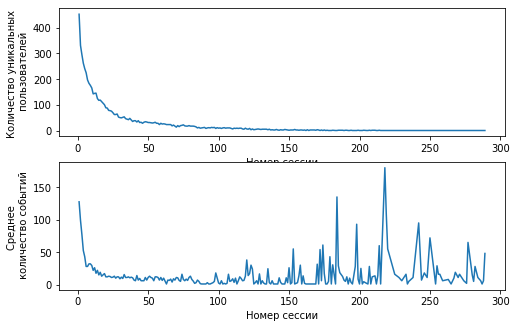

In [290]:
gridsize = (3, 2)
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)

ax1.plot(converse.columns, converse.loc['Количество уникальных пользователей'])
ax1.set_ylabel('Количество уникальных \n пользователей')
ax1.set_xlabel('Номер сессии')

ax2.plot(converse.columns, converse.loc['Среднее количество событий'])
ax2.set_ylabel('Среднее \n количество событий')
ax2.set_xlabel('Номер сессии')

plt.show()

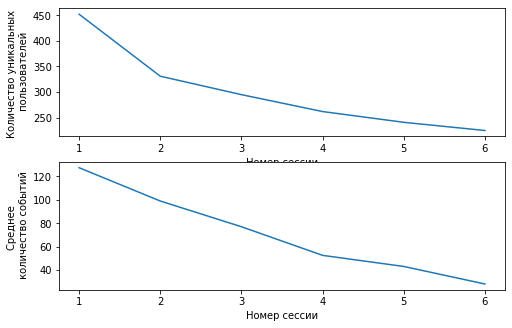

In [321]:
gridsize = (3, 2)
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)

ax1.plot(converse.columns[:6], converse.loc['Количество уникальных пользователей'][:6])
ax1.set_ylabel('Количество уникальных \n пользователей')
ax1.set_xlabel('Номер сессии')

ax2.plot(converse.columns[:6], converse.loc['Среднее количество событий'][:6])
ax2.set_ylabel('Среднее \n количество событий')
ax2.set_xlabel('Номер сессии')

plt.show()

 ---

In [311]:
converse1 = pd.DataFrame(index=['Количество уникальных пользователей', 
                               'Среднее количество событий'])
for i in np.sort(data_ch['session_index'].unique()):
    dt = data_ch[data_ch['session_index'] == i].groupby('user_id').count()
    dt = dt[dt['session_index'] != 1]
    converse1[i] = [dt['session_index'].shape[0],
                   dt['session_index'].quantile(0.5)]

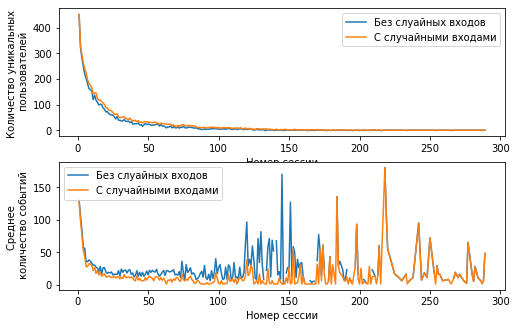

In [320]:
gridsize = (3, 2)
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)

ax1.plot(converse1.columns, converse1.loc['Количество уникальных пользователей'])
ax1.plot(converse.columns, converse.loc['Количество уникальных пользователей'])
ax1.set_ylabel('Количество уникальных \n пользователей')
ax1.set_xlabel('Номер сессии')
ax1.legend(['Без слуайных входов', 'С случайными входами'])

ax2.plot(converse1.columns, converse1.loc['Среднее количество событий'])
ax2.plot(converse.columns, converse.loc['Среднее количество событий'])
ax2.set_ylabel('Среднее \n количество событий')
ax2.set_xlabel('Номер сессии')
ax2.legend(['Без слуайных входов', 'С случайными входами'])
plt.savefig(r'C:\Users\home\Desktop\analysis\5.png')

plt.show()

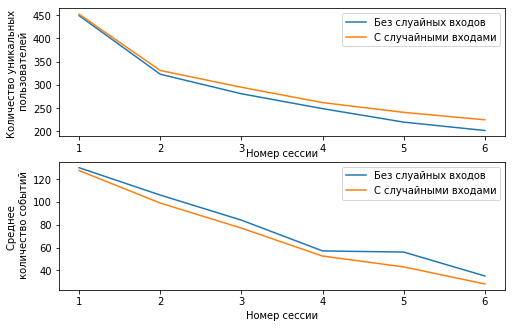

In [319]:
gridsize = (3, 2)
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)

ax1.plot(converse1.columns[:6], converse1.loc['Количество уникальных пользователей'][:6])
ax1.plot(converse.columns[:6], converse.loc['Количество уникальных пользователей'][:6])
ax1.set_ylabel('Количество уникальных \n пользователей')
ax1.set_xlabel('Номер сессии', labelpad=-5)
ax1.legend(['Без слуайных входов', 'С случайными входами'])

ax2.plot(converse1.columns[:6], converse1.loc['Среднее количество событий'][:6])
ax2.plot(converse.columns[:6], converse.loc['Среднее количество событий'][:6])
ax2.set_ylabel('Среднее \n количество событий')
ax2.set_xlabel('Номер сессии')
ax2.legend(['Без слуайных входов', 'С случайными входами'])

plt.savefig(r'C:\Users\home\Desktop\analysis\4.png')
plt.show()

---

In [327]:
data_full = data_ch.copy()

In [332]:
dummie = ['media_source', 'event_name', 'device_appInstall', 
          'inLevel_transactionComplete', 'productDescription_transactionComplete',
         'prediction_levelStart', 'retry_levelStart', 'fromMenu_levelEnd',
         'win_levelEnd', 'prediction_levelEnd', 'predictionCameTrue_levelEnd',
         'type_getBooster', 'from_getBooster', 'from_getCoins',
         'name_learning']

In [335]:
for i in dummie:
    data_full = data_full.merge(pd.get_dummies(data_full[i], prefix=i), 
                               how='left', 
                               left_index=True, 
                               right_index=True)
    data_full = data_full.drop(i, axis=1)

In [340]:
data_full.head()

,user_id,client_time,session_index,graphicMemory_appInstall,systemMemory_appInstall,level_learning,amount_getCoins,amount_getBooster,time_levelEnd,level_levelEnd,...,name_learning_SLOTS_SPOTLIGHT_ON_BET_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_CURRENCY_COUNTER,name_learning_SLOTS_SPOTLIGHT_ON_LEADERBOARD,name_learning_SLOTS_SPOTLIGHT_ON_SPIN_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_WIDGET,name_learning_SLOTS_TUTORIAL_REWARD,name_learning_STREAK_INFO,name_learning_UNLIMITED_TIP_OF_USING_AVAILABLE_WILD_CARD,name_learning_USE_UNDO,name_learning_USE_WILD_CARD
0,60c588d7b4d1b24b40531f29,2021-06-05 07:23:06,1,2048,5582,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,60d34c7ab4d1b24b405324ac,2021-06-05 16:33:26,1,256,892,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,60babef87c80da6a9442cb86,2021-06-05 00:02:07,1,2048,5562,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,60bac0e912667e6a8d107731,2021-06-05 00:04:29,1,512,1847,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,60babfb17c80da6a9442cb87,2021-06-05 00:05:16,1,2048,5616,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


---

In [923]:
data_full_1 = data_full.loc[data_full['session_index'] == 1]

In [924]:
data_full_count_1 = data_full_1.groupby(['user_id']).mean()

In [925]:
data_full_count_1.head()

,session_index,coins_game_status,freeRounds_game_status,freeUndo_game_status,freeWildCard_game_status,freeAddCards_game_status,level_game_status,map_game_status,bet_game_status,gladeId_game_status,...,name_learning_SLOTS_SPOTLIGHT_ON_BET_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_CURRENCY_COUNTER,name_learning_SLOTS_SPOTLIGHT_ON_LEADERBOARD,name_learning_SLOTS_SPOTLIGHT_ON_SPIN_BUTTON,name_learning_SLOTS_SPOTLIGHT_ON_WIDGET,name_learning_SLOTS_TUTORIAL_REWARD,name_learning_STREAK_INFO,name_learning_UNLIMITED_TIP_OF_USING_AVAILABLE_WILD_CARD,name_learning_USE_UNDO,name_learning_USE_WILD_CARD
user_id,,,,,,,,,,,,,,,,,,,,,
605717849c72f901462a2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60ba837f4770af6a2faa0544,1,22891.361446,0.060241,2.048193,3.152610,1.092369,25.943775,1.0,1.566265,1.783133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60ba999a73c31e6a292b7a2b,1,17204.620690,0.000000,4.827586,4.482759,4.655172,1.275862,1.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60babef87c80da6a9442cb86,1,9385.139535,0.465116,2.930233,2.441860,3.046512,4.790698,1.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60babfb17c80da6a9442cb87,1,4189.714286,0.000000,2.785714,2.357143,2.571429,0.714286,1.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

In [926]:
data_full_2 = data_full.loc[data_full['session_index'] == 2]
data_full_count_2 = data_full_2.groupby(['user_id']).mean()

In [927]:
goal_1_2 = pd.DataFrame(index=data_full_count_1.index, columns=['target'])
for i in goal_1_2.index:
    if i in data_full_count_2.index:
        goal_1_2['target'].loc[i] = 1
    else:
        goal_1_2['target'].loc[i] = 0

In [928]:
from sklearn.ensemble import GradientBoostingClassifier

In [929]:
model = GradientBoostingClassifier()

In [930]:
model.fit(data_full_count_1, goal_1_2)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier()

In [931]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(data_full_count_1.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(20)

,feature,importance
0,freeRounds_game_status,0.096927
1,name_learning_CRUISE_GET_CARD_FROM_DECK_MORE,0.045552
2,prediction_levelEnd_VictoryWith4OrMoreCards,0.043501
3,from_getCoins_LevelStart,0.041939
4,event_name_levelEnd,0.034443
5,from_getCoins_Harvest,0.033263
6,media_source_ad-traffic,0.028196
7,type_getBooster_freeUndo,0.027025
8,name_learning_CRUISE_STREAK_STAR,0.025374
9,freeUndo_game_status,0.023452


In [938]:
important_features = feature_results.feature[:6].values 

In [939]:
model.fit(data_full_count_1[important_features], goal_1_2)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier()

In [940]:
# Extract the feature importances into a dataframe
feature_results1 = pd.DataFrame({'feature': list(important_features), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results1 = feature_results1.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results1.head(20)

,feature,importance
0,freeRounds_game_status,0.215699
1,from_getCoins_Harvest,0.191036
2,from_getCoins_LevelStart,0.160264
3,name_learning_CRUISE_GET_CARD_FROM_DECK_MORE,0.156360
4,event_name_levelEnd,0.142237
5,prediction_levelEnd_VictoryWith4OrMoreCards,0.134404


In [811]:
data_full_count_1[important_features].head()

,freeRounds_game_status,prediction_levelEnd_VictoryWith4OrMoreCards,name_learning_CRUISE_GET_CARD_FROM_DECK_MORE,from_getCoins_LevelStart,event_name_levelEnd,prediction_levelStart_Default,from_getCoins_Harvest
user_id,,,,,,,
605717849c72f901462a2019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60ba837f4770af6a2faa0544,0.060241,0.008032,0.164659,0.060241,0.072289,0.004016,0.004016
60ba999a73c31e6a292b7a2b,0.000000,0.000000,0.000000,0.068966,0.068966,0.068966,0.000000
60babef87c80da6a9442cb86,0.465116,0.023256,0.069767,0.023256,0.069767,0.023256,0.023256
60babfb17c80da6a9442cb87,0.000000,0.000000,0.000000,0.000000,0.071429,0.071429,0.071429


----

In [831]:
data_full_3 = data_full.loc[data_full['session_index'] == 3]
data_full_count_3 = data_full_3.groupby(['user_id']).mean()

In [832]:
goal_2_3 = pd.DataFrame(index=data_full_count_2.index, columns=['target'])
for i in goal_2_3.index:
    if i in data_full_count_3.index:
        goal_2_3['target'].loc[i] = 1
    else:
        goal_2_3['target'].loc[i] = 0

In [833]:
model.fit(data_full_count_2, goal_2_3)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier()

In [834]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(data_full_count_2.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(20)

,feature,importance
0,from_getCoins_LevelBonus,0.098979
1,level_game_status,0.059542
2,freeUndo_game_status,0.041376
3,from_getCoins_AddCards,0.039197
4,coins_game_status,0.034540
5,type_getBooster_freeExtraCards,0.029908
6,from_getCoins_GetWildCard,0.027638
7,name_learning_CRUISE_AVAILABLE_WILD_CARD,0.024863
8,from_getCoins_GemHunt_TournamentLeaderboardReward,0.023218
9,prediction_levelStart_VictoryWith1Or2Cards,0.022637


In [844]:
important_features = feature_results.feature[:5].values 

In [845]:
model.fit(data_full_count_2[important_features], goal_2_3)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier()

In [846]:
# Extract the feature importances into a dataframe
feature_results1 = pd.DataFrame({'feature': list(important_features), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results1 = feature_results1.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results1.head(20)

,feature,importance
0,from_getCoins_LevelBonus,0.269653
1,coins_game_status,0.245589
2,level_game_status,0.200935
3,freeUndo_game_status,0.178825
4,from_getCoins_AddCards,0.104997


---

In [847]:
data_full_4 = data_full.loc[data_full['session_index'] == 4]
data_full_count_4 = data_full_4.groupby(['user_id']).mean()

In [848]:
goal_3_4 = pd.DataFrame(index=data_full_count_3.index, columns=['target'])
for i in goal_3_4.index:
    if i in data_full_count_4.index:
        goal_3_4['target'].loc[i] = 1
    else:
        goal_3_4['target'].loc[i] = 0

In [849]:
model.fit(data_full_count_3, goal_3_4)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier()

In [850]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(data_full_count_2.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(20)

,feature,importance
0,freeWildCard_game_status,0.053554
1,coins_game_status,0.053295
2,freeAddCards_game_status,0.052915
3,freeRounds_game_status,0.049567
4,from_getCoins_UndoCardFromDeck,0.046419
5,prediction_levelEnd_DefeatWith1Or2Cards,0.045486
6,from_getCoins_GemHunt_TournamentStageReward,0.045100
7,freeUndo_game_status,0.043858
8,event_name_learning,0.041679
9,level_game_status,0.036893


In [851]:
important_features = feature_results.feature[:6].values 

In [852]:
model.fit(data_full_count_3[important_features], goal_3_4)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingClassifier()

In [853]:
# Extract the feature importances into a dataframe
feature_results1 = pd.DataFrame({'feature': list(important_features), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results1 = feature_results1.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results1.head(20)

,feature,importance
0,coins_game_status,0.243872
1,freeAddCards_game_status,0.195015
2,freeWildCard_game_status,0.157589
3,from_getCoins_UndoCardFromDeck,0.149641
4,prediction_levelEnd_DefeatWith1Or2Cards,0.135990
5,freeRounds_game_status,0.117892


---

In [1380]:
data_full__1_important = data_full_1.groupby(['user_id']).sum()[important_features]

In [1363]:
data_full__1_important = data_full__1_important.merge(goal_1_2, how='left', left_on='user_id', right_on='user_id')

In [1364]:
a = data_full__1_important[data_full__1_important['target']==0]

In [1365]:
b = data_full__1_important[data_full__1_important['target']==1]

In [1366]:
a = resample(a, 
            n_samples=100,
            random_state=312)

In [1367]:
b = resample(b, 
            n_samples=100,
            random_state=3221)

In [1368]:
dfi = pd.concat([a, b])

In [1369]:
probability = pd.DataFrame(index=list(np.arange(0.01,0.99,0.01)), columns=dfi.columns[:-1])
for col in dfi.columns[:-1]:
    for i in np.arange(0.01,0.99,0.01):
        probability[col].loc[i] = dfi[dfi[col]>=dfi[col].quantile(i)]['target'].mean()

In [1373]:
for col in probability.columns:
    print(col, probability[col].iloc[34:35].max(),
          dfi[col].quantile(float(probability[probability[col] >= probability[col].iloc[35:36].max()].index[0])))

freeRounds_game_status 0.5579710144927537 10.720000000000006
name_learning_CRUISE_GET_CARD_FROM_DECK_MORE 0.49624060150375937 0.0
prediction_levelEnd_VictoryWith4OrMoreCards 0.5 0.0
from_getCoins_LevelStart 0.5615384615384615 1.6499999999999915
event_name_levelEnd 0.5692307692307692 4.6499999999999915
from_getCoins_Harvest 0.5370370370370371 0.8100000000000023


In [1372]:
for col in probability.columns:
    print(col, probability[col].iloc[64:65].max(),
          dfi[col].quantile(float(probability[probability[col] == probability[col].iloc[63:64].max()].index[0])))

freeRounds_game_status 0.5492957746478874 28.0
name_learning_CRUISE_GET_CARD_FROM_DECK_MORE 0.5142857142857142 0.0
prediction_levelEnd_VictoryWith4OrMoreCards 0.5540540540540541 2.3700000000000045
from_getCoins_LevelStart 0.5633802816901409 13.36
event_name_levelEnd 0.5571428571428572 16.72
from_getCoins_Harvest 0.5370370370370371 0.8100000000000023


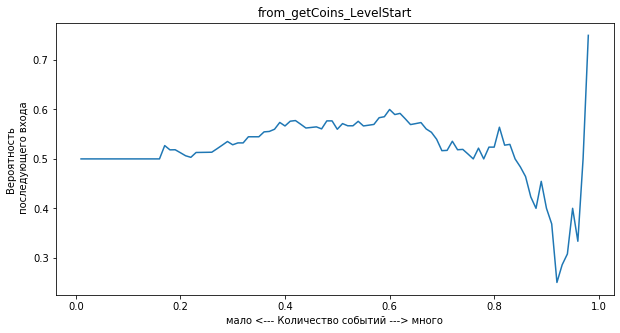

In [1320]:
fig=plt.figure(figsize=(10,5))
plt.ylabel('Вероятность \n последующего входа')
plt.xlabel('мало <--- Количество событий ---> много')
# plt.plot(probability.index, probability['freeRounds_game_status'])
# plt.plot(probability.index, probability['name_learning_CRUISE_GET_CARD_FROM_DECK_MORE'])
# plt.plot(probability.index, probability['prediction_levelEnd_VictoryWith4OrMoreCards'])
plt.plot(probability.index, probability['from_getCoins_LevelStart'])
# plt.plot(probability.index, probability['event_name_levelEnd'])
# plt.plot(probability.index, probability['from_getCoins_Harvest'])
plt.title('from_getCoins_LevelStart')
plt.savefig(r'C:\Users\home\Desktop\analysis\from_getCoins_LevelStart.png')

---

In [1394]:
data_full__1_important = data_full_1.groupby(['user_id']).sum()[important_features]
data_full__1_important = data_full__1_important.merge(goal_1_2, how='left', left_on='user_id', right_on='user_id')

In [1395]:
group_a = data_full__1_important.loc[np.logical_and(data_full__1_important['from_getCoins_LevelStart']>=2,
                                                   data_full__1_important['from_getCoins_LevelStart']<=13)]

In [1396]:
group_b = data_full__1_important.loc[np.logical_or(data_full__1_important['from_getCoins_LevelStart'] <2,
                                                    data_full__1_important['from_getCoins_LevelStart']>13)]

In [1401]:
conversion = pd.DataFrame(index=['Группа H0', 'Группа H1'], 
                          columns=['Количество наблюдений', 'Количество повторных сессий', 'Конверсия'])

In [1408]:
conversion.iloc[0] = [group_a.shape[0], group_a['target'].sum(), group_a['target'].mean()]
conversion.iloc[1] = [group_b.shape[0], group_b['target'].sum(), group_b['target'].mean()]

In [1409]:
conversion

,Количество наблюдений,Количество повторных сессий,Конверсия
Группа H0,160,126,0.7875
Группа H1,292,205,0.702055


In [1419]:
import statsmodels.api as sm

In [1421]:
z, p_value =  sm.stats.proportions_ztest([conversion['Количество повторных сессий'].iloc[0], 
                                          conversion['Количество повторных сессий'].iloc[1]],
                                         [conversion['Количество наблюдений'].iloc[0], 
                                          conversion['Количество наблюдений'].iloc[1]])

In [1431]:
print('z:',z,
     'p_value:',p_value)

z: 1.9620119622844294 p_value: 0.049761091568244174


---

# Point 1.2

#### Изучите то, как пользователи взаимодействуют с игровыми уровнями. Оцените качество первых 30 уровней игры: какие уровни хороши, какие нет и почему?

In [1549]:
levels_end = data_full.loc[np.logical_and(data_full['levelLoop_levelEnd']>=1, data_full['levelLoop_levelEnd']<=30)]

In [1550]:
levels_end_grouped = levels_end.groupby('levelLoop_levelEnd').mean()

In [1551]:
zz = pd.DataFrame(index=levels_end_grouped.columns)
zz[1] = levels_end_grouped.mean()

In [1552]:
needed_columns = zz.loc[zz[1]!=0].index

In [1553]:
levels_end_grouped = levels_end_grouped[needed_columns]

In [1554]:
levels_end_grouped[levels_end_grouped.columns[:10]].describe()

,session_index,coins_game_status,freeRounds_game_status,freeUndo_game_status,freeWildCard_game_status,freeAddCards_game_status,level_game_status,map_game_status,bet_game_status,gladeId_game_status
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.0,26.000000,26.000000
mean,2.000943,12948.179048,0.090998,2.344008,2.456151,1.679579,16.500000,1.0,1.053009,1.933151
std,1.063374,3925.531820,0.283944,0.685913,0.609837,1.169351,8.046117,0.0,0.179116,1.092776
min,1.000000,5007.086310,0.000000,1.000000,1.000000,0.000000,1.000000,1.0,1.000000,1.000000
25%,1.180906,9624.625000,0.000000,1.950704,2.041667,0.604167,10.250000,1.0,1.000000,1.020727
50%,1.601579,12726.898867,0.000000,2.382252,2.740190,2.100696,16.500000,1.0,1.000000,1.565476
75%,2.500000,16280.595169,0.035131,2.601165,2.833571,2.632832,22.750000,1.0,1.000000,2.425000
max,4.428571,20721.200000,1.375405,4.000000,3.333333,3.165541,30.000000,1.0,1.676364,4.000000


In [1555]:
levels_end_grouped[levels_end_grouped.columns[10:20]].describe()

,media_source_ad-traffic,media_source_organic,event_name_levelEnd,fromMenu_levelEnd_false,fromMenu_levelEnd_true,win_levelEnd_DEFEAT,win_levelEnd_DEFEAT_WITH_BOOSTER,win_levelEnd_NONE,win_levelEnd_VICTORY,win_levelEnd_VICTORY_WITH_BOOSTER
count,26.000000,26.000000,26.0,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.225579,0.774421,1.0,0.999029,0.000971,0.042734,0.000639,0.000971,0.611796,0.343860
std,0.209237,0.209237,0.0,0.002958,0.002958,0.134883,0.001586,0.002958,0.330706,0.314681
min,0.000000,0.545455,1.0,0.987055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.561091,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.408002,0.110570
50%,0.250000,0.750000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.702424,0.211872
75%,0.438909,1.000000,1.0,1.000000,0.000000,0.006881,0.000000,0.000000,0.878268,0.539948
max,0.454545,1.000000,1.0,1.000000,0.012945,0.500000,0.005988,0.012945,1.000000,1.000000


In [1556]:
levels_end_grouped[levels_end_grouped.columns[20:]].describe()

,prediction_levelEnd_Default,prediction_levelEnd_DefeatWith1Or2Cards,prediction_levelEnd_DefeatWith3OrMoreCards,prediction_levelEnd_DefeatWith5OrMoreCards,prediction_levelEnd_VictoryWith0Cards,prediction_levelEnd_VictoryWith1Or2Cards,prediction_levelEnd_VictoryWith4OrMoreCards,predictionCameTrue_levelEnd_false,predictionCameTrue_levelEnd_true
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.038462,0.188950,0.089664,0.023519,0.341860,0.150495,0.167050,0.300553,0.699447
std,0.196116,0.247456,0.199856,0.097924,0.248470,0.144177,0.160473,0.355914,0.355914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.180319,0.000000,0.000000,0.016608,0.509752
50%,0.000000,0.075071,0.000000,0.000000,0.313431,0.119787,0.174153,0.157407,0.842593
75%,0.000000,0.321429,0.011907,0.000000,0.500000,0.293792,0.328273,0.490248,0.983392
max,1.000000,1.000000,0.666667,0.500000,1.000000,0.400000,0.444444,1.000000,1.000000


In [1582]:
columns_interesting = ['win_levelEnd_DEFEAT', 'win_levelEnd_VICTORY', 'win_levelEnd_DEFEAT_WITH_BOOSTER',
                       'win_levelEnd_VICTORY_WITH_BOOSTER', 
                       'prediction_levelEnd_DefeatWith3OrMoreCards', 'prediction_levelEnd_DefeatWith1Or2Cards',
                      'prediction_levelEnd_DefeatWith5OrMoreCards', 'prediction_levelEnd_VictoryWith0Cards',
                      'predictionCameTrue_levelEnd_true', 'predictionCameTrue_levelEnd_false']

In [1589]:
levels_end_grouped[columns_interesting].head()

,win_levelEnd_DEFEAT,win_levelEnd_VICTORY,win_levelEnd_DEFEAT_WITH_BOOSTER,win_levelEnd_VICTORY_WITH_BOOSTER,prediction_levelEnd_DefeatWith3OrMoreCards,prediction_levelEnd_DefeatWith1Or2Cards,prediction_levelEnd_DefeatWith5OrMoreCards,prediction_levelEnd_VictoryWith0Cards,predictionCameTrue_levelEnd_true,predictionCameTrue_levelEnd_false
levelLoop_levelEnd,,,,,,,,,,
1,0.000000,0.982143,0.0,0.011905,0.0,0.0,0.000000,0.000000,0.000000,1.000000
5,0.000000,0.000000,0.0,1.000000,0.0,1.0,0.000000,0.000000,0.000000,1.000000
6,0.003175,0.822222,0.0,0.168254,0.0,0.0,0.000000,0.250794,0.990476,0.009524
7,0.006472,0.841424,0.0,0.139159,0.0,0.0,0.006472,0.339806,0.974110,0.025890
8,0.003311,0.903974,0.0,0.092715,0.0,0.0,0.000000,0.341060,0.996689,0.003311


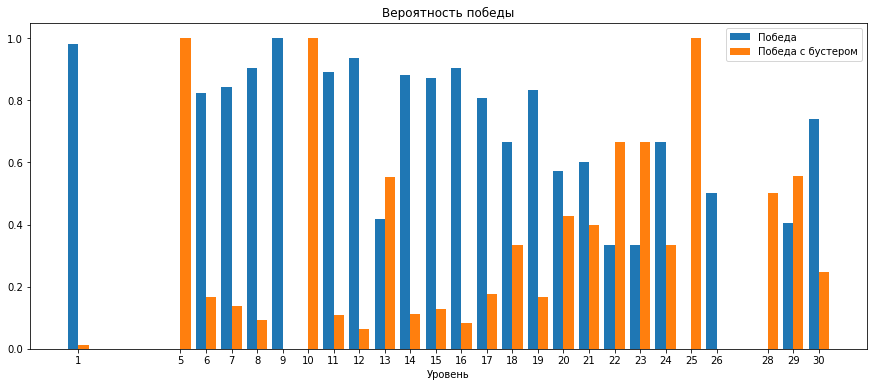

In [1588]:
fig,ax = plt.subplots(figsize=(15,6))
ax.bar(levels_end_grouped.index-0.2, levels_end_grouped['win_levelEnd_VICTORY'], width = 0.4)
ax.bar(levels_end_grouped.index+0.2, levels_end_grouped['win_levelEnd_VICTORY_WITH_BOOSTER'], width = 0.4)
plt.xticks(levels_end_grouped.index)
plt.title('Вероятность победы')
plt.xlabel('Уровень')
plt.legend(['Победа', 'Победа с бустером'])
plt.savefig(r'C:\Users\home\Desktop\analysis\win_levelEnd_VICTORY2.png')
plt.show()

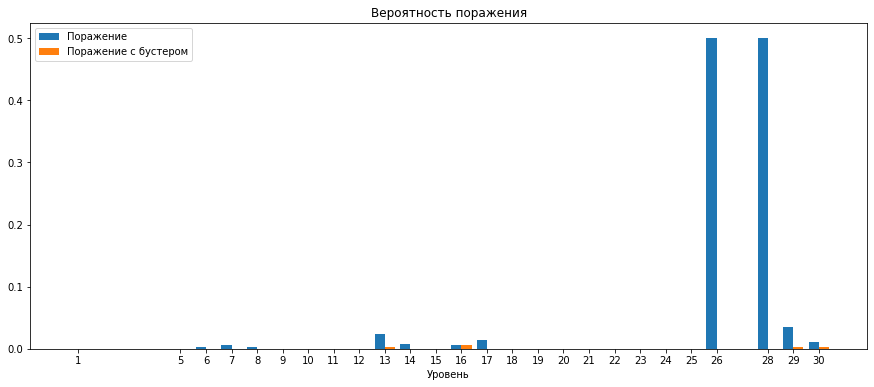

In [1590]:
fig,ax = plt.subplots(figsize=(15,6))
ax.bar(levels_end_grouped.index-0.2, levels_end_grouped['win_levelEnd_DEFEAT'], width = 0.4)
ax.bar(levels_end_grouped.index+0.2, levels_end_grouped['win_levelEnd_DEFEAT_WITH_BOOSTER'], width = 0.4)
plt.xticks(levels_end_grouped.index)
plt.title('Вероятность поражения')
plt.xlabel('Уровень')
plt.legend(['Поражение', 'Поражение с бустером'])
plt.savefig(r'C:\Users\home\Desktop\analysis\win_levelEnd_DEFEAT.png')
plt.show()

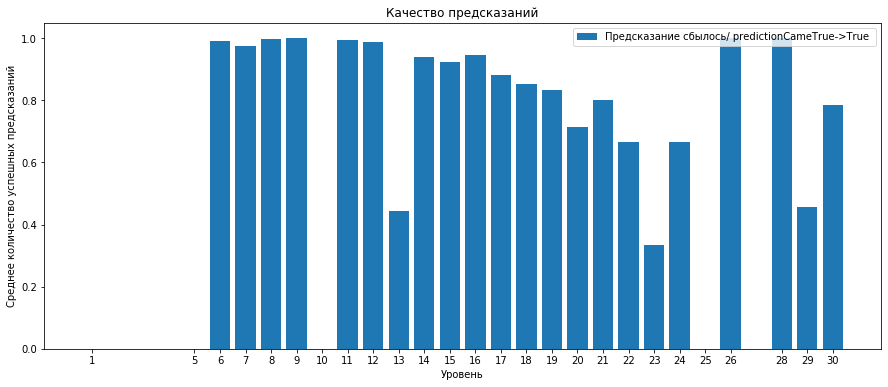

In [1591]:
fig,ax = plt.subplots(figsize=(15,6))
ax.bar(levels_end_grouped.index, levels_end_grouped['predictionCameTrue_levelEnd_true'])
# ax.bar(levels_end_grouped.index+0.2, levels_end_grouped['win_levelEnd_DEFEAT_WITH_BOOSTER'], width = 0.4)
plt.xticks(levels_end_grouped.index)
plt.title('Качество предсказаний')
plt.xlabel('Уровень')
plt.ylabel('Среднее количество успешных предсказаний')
plt.legend(['Предсказание сбылось/ predictionCameTrue->True '])
plt.savefig(r'C:\Users\home\Desktop\analysis\predictionCameTrue_levelEnd_true.png')
plt.show()

---

# Point 1.3 

#### Часть пользователей в датасете пришли по одной рекламной кампании (media_source = ad-traffic). Для нее мы знаем CPI:
#### ● CPI = 1,8 USD
#### Оцените эффективность этой рекламной кампании

In [1730]:
media_evaluating = data_ch[['user_id', 'media_source', 'usdProceed_transactionComplete']]

In [1731]:
media_evaluating = media_evaluating[media_evaluating['media_source']=='ad-traffic']

In [1732]:
media_evaluating = media_evaluating.drop('media_source', axis=1)

In [1733]:
media_evaluating = media_evaluating.fillna(0)

In [1734]:
media_evaluating['usdProceed_transactionComplete'] = media_evaluating['usdProceed_transactionComplete'].astype(int)

In [1736]:
# media_evaluating = media_evaluating.drop('user_id', axis=1)

In [1741]:
media_evaluating_grouped = media_evaluating.groupby(['user_id']).sum()

In [1742]:
media_evaluating_grouped

,usdProceed_transactionComplete
user_id,
60babef87c80da6a9442cb86,0
60bac0e912667e6a8d107731,0
60bac42973c31e6a292b7a3a,0
60bac4ba12667e6a8d107733,0
60bac5e912667e6a8d107735,0
...,...
60bbff4612667e6a8d1077b4,0
60bc02944770af6a2faa05ec,0
60bc044d7c80da6a9442cc1d,0


In [1765]:
media_evaluating_data.loc['ad_trafic'] = [media_evaluating_grouped.shape[0],
                                            1.8,
                                            media_evaluating_grouped.shape[0]*1.8,
                                            media_evaluating_grouped[media_evaluating_grouped['usdProceed_transactionComplete']>0].shape[0],
                                            media_evaluating_grouped['usdProceed_transactionComplete'].sum(),
                                            (media_evaluating_grouped['usdProceed_transactionComplete'].sum())/(media_evaluating_grouped.shape[0]*1.8)
                                            ]

In [1766]:
media_evaluating_data

,Количество игроков,Стоимость одного игрока USD,Сумма рекламной компании USD,"Количество игроков, которые совершили покупку",Сумма покупок USD,Эффективность рекламной компании
ad_trafic,159,1.8,286.2,7,49,0.171209


---